# Continuously Maintaining Quantile Summaries of the Most Recent N Elements over a Data Stream

Lin et al. did a great job on creating quantile summaries. 

When considering stream of data last N elements often are the most interesting to us. Here the Sliding Window algorithm becomes handy.

The algorithm takes space of:
    \begin{align}
        O(\frac{log(ϵ^2 N)}{ϵ} + \frac{1}{ϵ^2})
    \end{align}
    

In this notebook you will see:
- the implementation of the Sliding Window(SW) algorithm
- implementation of the Greenwald-Khanna algorithm(will be used for SW)
- Simulate data and run your implementation
- Plot graphs of time and space consumption (compare to the paper)

In [ ]:
import numpy as np
import math
from copy import deepcopy
from typing import List

## Greenwald-Khanna


Following code has been taken from the [this](https://github.com/DataDog/sketches-py) repository.

In [ ]:
DEFAULT_EPS = 0.01


class UnequalEpsilonException(Exception):
    pass


class Entry(object):

    def __init__(self, val, g, delta):
        self.val = val
        self.g = g
        self.delta = delta

    def __repr__(self):
        return 'Entry(val={}, g={}, delta={})'.format(self.val, self.g, self.delta)


class GKArray(object):

    def __init__(self, eps=None):
        if eps is None or eps <= 0 or eps >= 1:
            self.eps = DEFAULT_EPS
        else:
            self.eps = eps
        self.entries = []
        self.incoming = []
        self._min = float('+inf')
        self._max = float('-inf')
        self._count = 0
        self._sum = 0

    def __repr__(self):
        return "entries: {}, incoming: {}, count: {}, min: {}, max: {}, sum: {}\n".format(
            self.entries, self.incoming, self._count, self._min, self._max, self._sum)

    @property
    def name(self):
        return 'GKArray'

    @property
    def num_values(self):
        return self._count

    @property
    def avg(self):
        return float(self._sum)/self._count

    @property
    def sum(self):
        return self._sum

    def size(self):
        if len(self.incoming) > 0:
            self.merge_compress()
        return len(self.entries)

    def add(self, val):
        """ Add a value to the sketch.
        """
        self.incoming.append(val)
        self._count += 1
        self._sum += val
        if val < self._min:
            self._min = val
        if val > self._max:
            self._max = val
        if self._count % (int(1.0/self.eps) + 1) == 0:
            self.merge_compress()

    def merge_compress(self, entries=[]):
        """ Merge the given entry list into self.entries as well as compressing any values in
        self.incoming buffer.

        Parameters:
            entries: list of Entry
        """
        removal_threshold = np.floor(2.0*self.eps*(self._count - 1))
        incoming = [Entry(val, 1, 0) for val in self.incoming] + [Entry(e.val, e.g, e.delta) for e in entries]
        incoming = sorted(incoming, key=lambda x: x.val)

        merged = []
        i, j = 0, 0
        while i < len(incoming) or j < len(self.entries):
            if i == len(incoming):
                # done with incoming; now only considering entries
                if j + 1 < len(self.entries) and\
                   self.entries[j].g + self.entries[j+1].g + self.entries[j+1].delta <= removal_threshold:
                    self.entries[j+1].g += self.entries[j].g
                else:
                    merged.append(self.entries[j])
                j += 1
            elif j == len(self.entries):
                # done with entries; now only considering incoming
                if i+1 < len(incoming) and\
                   incoming[i].g + incoming[i+1].g + incoming[i+1].delta <= removal_threshold:
                    incoming[i+1].g += incoming[i].g
                else:
                    merged.append(incoming[i])
                i += 1
            elif incoming[i].val < self.entries[j].val:
                if incoming[i].g + self.entries[j].g + self.entries[j].delta <= removal_threshold:
                    self.entries[j].g += incoming[i].g
                else:
                    incoming[i].delta = self.entries[j].g + self.entries[j].delta - incoming[i].g
                    merged.append(incoming[i])
                i += 1
            else:
                if j + 1 < len(self.entries) and\
                   self.entries[j].g + self.entries[j+1].g + self.entries[j+1].delta <= removal_threshold:
                    self.entries[j+1].g += self.entries[j].g
                else:
                    merged.append(self.entries[j])
                j += 1

        self.entries = merged
        self.incoming = []

    def merge(self, sketch):
        """ Merge another GKArray into the current. The two sketches should have the same
        epsilon value.

        Parameters:
            other: GKArray
        """
        if self.eps != sketch.eps:
            raise UnequalEpsilonException("Cannot merge two GKArrays with different epsilon values")

        if sketch._count == 0:
            return

        if self._count == 0:
            self.entries = [Entry(e.val, e.g, e.delta) for e in sketch.entries]
            self.incoming = sketch.incoming[:]
            self._min = sketch._min
            self._max = sketch._max
            self._count = sketch._count
            self._sum = sketch._sum
            return

        entries = []
        spread = int(sketch.eps*(sketch._count - 1))
        sketch.merge_compress()
        g = sketch.entries[0].g + sketch.entries[0].delta - spread - 1
        if g > 0:
            entries.append(Entry(sketch._min, g, 0))
        for i in range(len(sketch.entries)-1):
            g = sketch.entries[i+1].g + sketch.entries[i+1].delta - sketch.entries[i].delta
            if g > 0:
                entries.append(Entry(sketch.entries[i].val, g, 0))
        g = spread + 1 - sketch.entries[len(sketch.entries) - 1].delta
        if g > 0:
            entries.append(Entry(sketch.entries[len(sketch.entries) - 1].val, g, 0))
        
        self._count += sketch._count
        self._sum += sketch._sum
        self._min = min(self._min, sketch._min)
        self._max = max(self._max, sketch._max)

        self.merge_compress(entries)

    def quantile(self, q):
        """ Return an epsilon-approximate element at quantile q.

        Parameters:
            q: quantile to query for
               0 <= q <= 1
        """
        if q < 0 or q > 1 or self._count == 0:
            return np.nan

        if len(self.incoming) > 0:
            self.merge_compress()

        rank = int(q*(self._count - 1) + 1)
        spread = int(self.eps*(self._count - 1))
        g_sum = 0.0
        i = 0
        while i < len(self.entries):
            g_sum += self.entries[i].g
            if g_sum + self.entries[i].delta > rank + spread:
                    break
            i += 1
        if i == 0:
            return self._min

        return self.entries[i-1].val

## Sliding Window Implementation


According to Lin et al. "model where quantile summaries are maintained for the N most recently seen elements in a data stream, we developed a one-pass deterministic ϵ-approximate algorithm to maintain quantiles summaries."


Summary of the technique

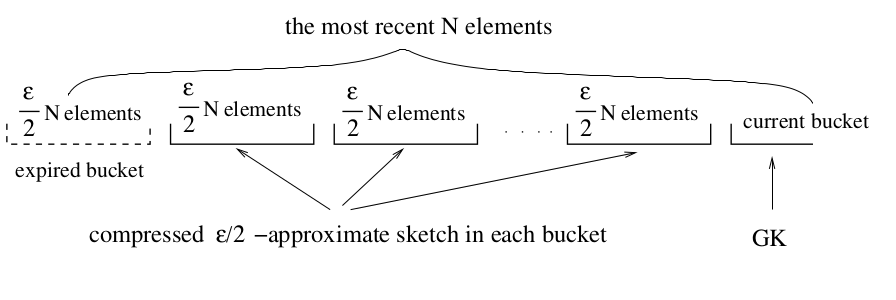

In [ ]:
from copy import deepcopy


def get_len(sketches):
    count = 0
    for sketch in sketches:
        count += sketch.size()
    return count


def pop_smallest_v_ij(sketches):
    assert get_len(sketches) != 0, "number of elements is 0"

    min_v_ij = min_i = min_j = math.inf

    for i, sketch in enumerate(sketches):
        for j, entry in enumerate(sketch.entries):
            if entry.val < min_v_ij:
                min_v_ij = entry.val
                min_i = i
                min_j = j


    entry = sketches[min_i].entries[min_j]
    del sketches[min_i].entries[min_j]
    return entry, min_i


def merge(sketches, eta):
    """
        :returns - merged sketches
    """
    sketches_copy = deepcopy(sketches)
    ns = [sketch.num_values for sketch in sketches_copy]

    S_merge = []
    r_negs = [0]
    r_pos = []

    k = 0

    l = len(sketches)
    
    r_i_0_neg = [0] * l

    while get_len(sketches_copy) != 0:
        # choose the tuple (v_ij, r_ij_neg, r_ij_pos) with the smallest v_ij
        selected_entry, i = pop_smallest_v_ij(sketches_copy)

        k += 1
        v_k = selected_entry.val
        
        g = selected_entry.g - r_i_0_neg[i]
        r_k_neg = r_negs[k-1] + g
        r_negs.append(r_k_neg)
        

        if k == 1:
            r_k_pos = eta * sum(ns[:k]) + 1
            r_pos.append(r_k_pos)
        else:
            r_k_pos = r_negs[k-1] + 2 * eta * sum(ns[:k])
            r_pos.append(r_k_pos)
            delta = r_k_pos - r_k_neg
            S_merge.append(Entry(v_k, g, int(delta)))

    return S_merge

In [ ]:
def lift(sketch: List[Entry], N: int, zeta: float):
    """
        Arguments:
            sketch - 
            zeta - 
        Returns:
            S_lift
    """
    assert 0 <= zeta <= 1, "please provide valid value of zeta (0, 1)"

    S_lift = deepcopy(sketch)
    value = math.floor(zeta * 0.5 * N)

    for i in S_lift:
        i.delta += value
    
    return S_lift

In [ ]:
def sw_query(sketches: List[GKArray], phi, N, eps):
    # merge local sketches, where eta = eps / 2
    merged_sketches = merge(sketches, eps / 2) 
    # apply lifting, where zeta = eps
    S_lift = lift(merged_sketches, N, eps)

    rank = math.floor(phi * N)
    offset = eps * N
    r_neg = 0
    r_pos = 0

    for v_i in S_lift:
        cond = lambda r_neg, r_pos: rank - offset <= r_neg <= r_pos <= rank + offset

        r_neg += v_i.g
        r_pos += r_neg + v_i.delta

        if cond(r_neg, r_pos):
            return v_i

    return v_i

In [ ]:
def SW(stream: List[int], N:int , eps: float):
    """Function computes Sliding Window approximate quantiles

        Arguments:
            stream - sequence of data
            N - window size
            eps - approximation value. In range (0, 1)
    """
    # number of elements
    k: int = 0
    
    buckets: List = []
    current_bucket: GKArray = GKArray(eps= eps / 4)
    max_bucket_size: int = math.floor(eps * N * 0.5)

    for d in stream:
        k += 1
        
        # if the number of elements is greater than N then remove the oldest bucket
        if k == N + 1:
            del buckets[0]
            k -= max_bucket_size
        
        # if bucket is full then compress it and create new one
        if current_bucket.num_values >= max_bucket_size:
            # Once a bucket is full, its (eps / 4)- approximate sketch is compressed
            # into an (eps / 2) - approximate sketch
            current_bucket.merge_compress()

            # add it to the list of buckets
            buckets.append(current_bucket)
            # initialize new bucket
            current_bucket = GKArray(eps = eps / 4)

        # add element to the bucket
        current_bucket.add(d)
    
    return buckets

Let us test the algorithm on some data

In [ ]:
data_stream = [0, 1, 2, 3, 4, 10, 100, 12, 213, 130, 3249, 444, 599, 190, 120, 500]

N = 10
eps = 0.5

In [ ]:
output = SW(data_stream, N, eps)
output

[entries: [Entry(val=12, g=1, delta=0), Entry(val=100, g=1, delta=0)], incoming: [], count: 2, min: 12, max: 100, sum: 112,
 entries: [Entry(val=130, g=1, delta=0), Entry(val=213, g=1, delta=0)], incoming: [], count: 2, min: 130, max: 213, sum: 343,
 entries: [Entry(val=444, g=1, delta=0), Entry(val=3249, g=1, delta=0)], incoming: [], count: 2, min: 444, max: 3249, sum: 3693,
 entries: [Entry(val=190, g=1, delta=0), Entry(val=599, g=1, delta=0)], incoming: [], count: 2, min: 190, max: 599, sum: 789]

So we will make a query 0.2 quantile

In [ ]:
quantile = sw_query(output, phi=0.2, N=N, eps=eps)
quantile

Entry(val=100, g=1, delta=3)

### Tests


We will conduct experiments using same parameters as in the paper

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_stream = np.random.randint(0, 1e3, int(1e6))
N = int(800e3)
eps_values = [0.1, 0.075, 0.05, 0.025]

In [ ]:
space_usage = [len(SW(data_stream, N, eps)) for eps in eps_values]

CPU times: user 19.3 s, sys: 18.9 ms, total: 19.3 s
Wall time: 19.8 s


In [94]:
exec_times = []

for eps in eps_values:
    duration = %timeit -n1 -r1 -o SW(data_stream, N, eps)

    exec_times.append(duration.all_runs[0])

1 loop, best of 1: 5.3 s per loop
1 loop, best of 1: 4.68 s per loop
1 loop, best of 1: 4.99 s per loop
1 loop, best of 1: 4.77 s per loop


We will display the space consumption. It is totally correlating with paper analysis

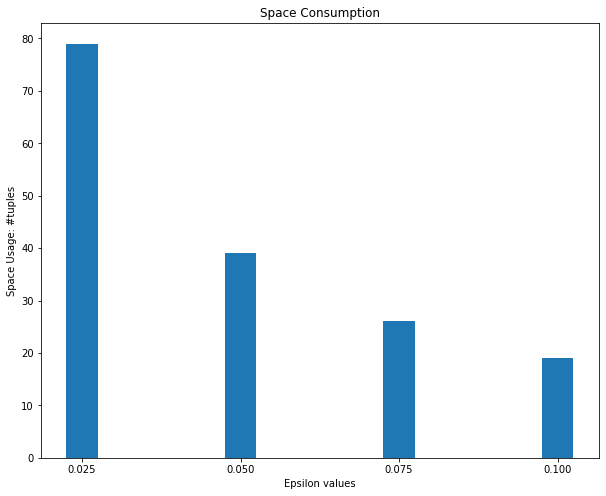

In [ ]:
figure = plt.figure(figsize=(10, 8))
plt.bar(eps_values, space_usage, width=0.005, align='center')

plt.xlabel('Epsilon values')
plt.ylabel('Space Usage: #tuples')

plt.xticks(eps_values)

plt.title('Space Consumption')

plt.show()

Performance measurements require more data to be captured to make accurate statements.

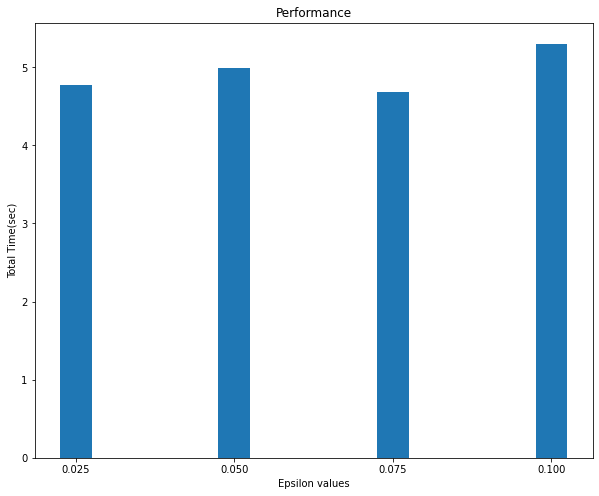

In [97]:
figure = plt.figure(figsize=(10, 8))
plt.bar(eps_values, exec_times, width=0.005, align='center')

plt.xlabel('Epsilon values')
plt.ylabel('Total Time(sec)')

plt.xticks(eps_values)

plt.title('Performance')

plt.show()